<h1>Here we set up the population synthesis model. We assume a constant star formation rate (SFR) over 12 Gyr (following El-Badry et al. 2018) and a total fractional mass loss given by Cummings et al. 2018.</h1>
Written by Nadia Zakamska, June 2024

In [1]:
# library imports
import numpy as np
from matplotlib import pyplot as plt
import sys
from astropy.table import Table
import rebound
from scipy.integrate import solve_ivp
from scipy import interpolate

# this is the library of helper functions provided separately, should be in the same folder as the notebook
import orbital
# this is the library of helper functions for the appendix
import ancillary

###Plot formatting commands
plt.rc('figure', figsize=(6,5)) 
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title
plt.rc('text', usetex=True)
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
###End formatting commands

In [2]:
# these are the parameters for the initial mass function
mmin=0.3
mbreak=0.5
mmax=7.2
alpha1=-1.3
alpha2=-2.3

In [3]:
# given a power-law distribution function for a variable y with y^alpha dy, generate samples 
# from it from a uniform distribution of x's. Those can be either evenly or randomly drawn. 
def gen_PL_sample(alpha,ymin,ymax,x):
    if (alpha==-1):
        koef_A=1./(np.log(ymax)-np.log(ymin))
        y=ymin*np.exp(x/koef_A)
    else:
        koef_A=(alpha+1.)/(ymax**(alpha+1)-ymin**(alpha+1))
        y=(x*(alpha+1.)/koef_A+ymin**(alpha+1))**(1./(alpha+1))
    return(y)

In [4]:
# same, but broken powerlaw, and let's ignore alpha=1 cases:
def gen_broken_PL(alpha1,alpha2,ymin,ybreak,ymax,x):
    if ((alpha1==-1) or (alpha2==-1)): 
        print('I cannot do this, I quit')
        return(x)
    # this is the normalization constant in front of g(y)dy to get it to integrate to 1:
    koef=1./(ybreak/(alpha1+1)*(1.-(ymin/ybreak)**(alpha1+1))+ybreak/(alpha2+1)*((ymax/ybreak)**(alpha2+1)-1.))
    # set an array of the same size:
    y=x*0.
    # compute the value of xbreak and figure out which x's are smaller than that:
    xbreak=koef*ybreak/(alpha1+1)*(1.-(ymin/ybreak)**(alpha1+1))
    ind=(x<xbreak)
    y[ind]=ybreak*(1.-x[ind]*(alpha1+1)/(ybreak*koef))**(1./(alpha1+1))
    ind=(x>=xbreak)
    y[ind]=ybreak*(1.+(x[ind]-xbreak)*(alpha2+1)/(ybreak*koef))**(1./(alpha2+1))
    return(y)

In [5]:
# we will probably run this with 1e6, but I have generated MS-MS plots with 1e7 
# to decrease shot noise for high-mass stars
nbinaries=10000000
np.random.seed(2022)
# number of bins for plotting 
n_bins=50

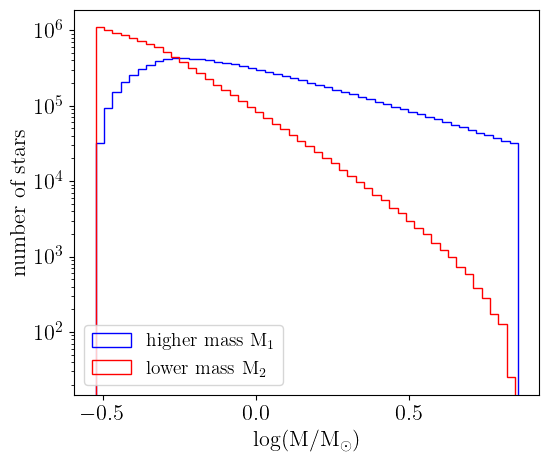

In [6]:
# Draw two masses independently from Kroupa IMF, this is true for wide binaries (Moe and Kratter)
xm1=np.random.uniform(size=nbinaries)
tempm1=gen_broken_PL(alpha1,alpha2,mmin,mbreak,mmax,xm1)
xm2=np.random.uniform(size=nbinaries)
tempm2=gen_broken_PL(alpha1,alpha2,mmin,mbreak,mmax,xm2)
# put the more massive one into m1; it will die off first
m2=np.minimum(tempm1,tempm2)
m1=np.maximum(tempm1,tempm2)
fig=plt.figure()
plt.hist(np.log10(m1), n_bins, histtype='step', stacked=True, fill=False, color='blue', label=r'higher mass M$_1$')
plt.hist(np.log10(m2), n_bins, histtype='step', stacked=True, fill=False, color='red', label=r'lower mass M$_2$')
plt.yscale('log')
plt.xlabel(r'log(M/M$_{\odot}$)')
plt.ylabel('number of stars')
plt.legend(loc='lower left')
plt.show()

In [7]:
# let's make a table:
mybinaries=Table()
mybinaries['m1']=m1
mybinaries['m2']=m2
# constant SFR means uniform birthday distribution from 0 to 12 Gyr, with 12 Gyr being present day: 
present_day=12.0 # in Gyr
mybinaries['bday']=np.random.uniform(size=nbinaries)*present_day

Generate separation distribution. Copying from Elbadry 2018: For systems where the primary mass is greater than 0.75Msun, we draw orbital periods from a lognormal distribution with log(P/day) = 4.8 and sigma log (P/day) = 2.3 (Duquennoy & Mayor 1991); for systems with lower mass primaries, we draw from a second lognormal with log(P/day) = 4.1 and sigma log (P/day) = 1.3 (Fischer & Marcy 1992).

In [8]:
# sanity check of a function in the orbital.py library: 
print('SMA of Earth in AU', orbital.sma(365.,1.,0.001))

SMA of Earth in AU 0.9989027352723391


In [9]:
# here it's important that m1 is the primary and it's the more massive of the two...
lgp1=np.random.normal(4.8,2.3,nbinaries) # Duquennoy Mayor 1991
lgp2=np.random.normal(4.1,1.3,nbinaries) # Fischer and Marcy 1992
lgp=lgp2
ind=(mybinaries['m1']>0.75)
lgp[ind]=lgp1[ind]
# this should be commented out:
# lgp=lgp1 # this is for the case public_setup_ms_ms_lgp1.png
mybinaries['sma']=orbital.sma(10**lgp,mybinaries['m1'],mybinaries['m2'])

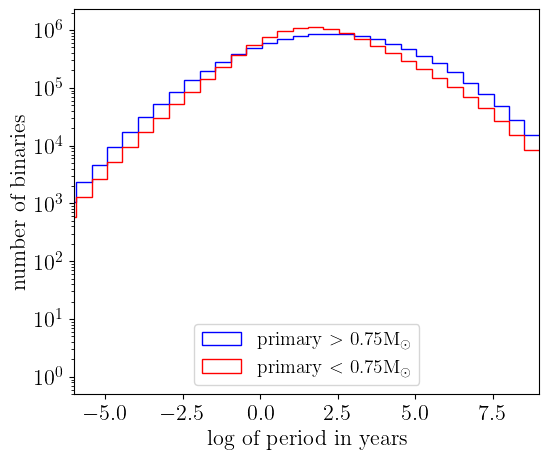

In [10]:
fig=plt.figure()
(n, bins, patches)=plt.hist(lgp1-np.log10(365.), n_bins, histtype='step', stacked=True, fill=False, color='blue', label=r'primary $>$ 0.75M$_{\odot}$')
plt.hist(lgp2-np.log10(365.), bins, histtype='step', stacked=True, fill=False, color='red', label=r'primary $<$ 0.75M$_{\odot}$')
plt.yscale('log')
plt.xlabel('log of period in years')
plt.ylabel('number of binaries')
plt.legend(loc='lower center')
plt.xlim((-6.,9.))
plt.show()

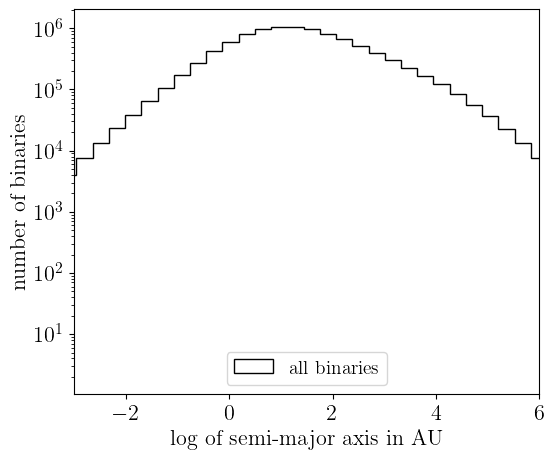

In [11]:
fig=plt.figure()
plt.hist(np.log10(mybinaries['sma']), n_bins, histtype='step', stacked=True, fill=False, color='black', label='all binaries')
plt.yscale('log')
plt.xlim((-3.,6.))
plt.xlabel('log of semi-major axis in AU')
plt.ylabel('number of binaries')
plt.legend(loc='lower center')
plt.show()

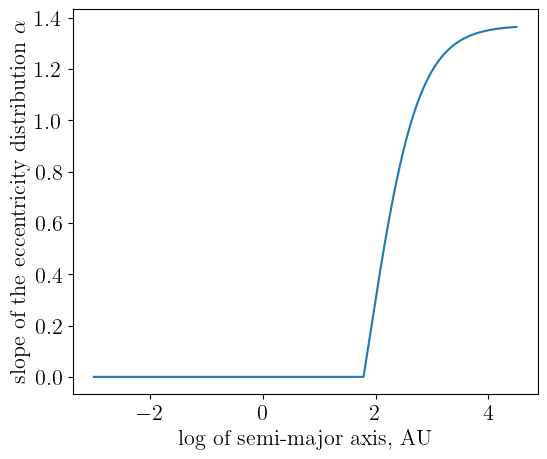

In [12]:
# Hwang et al. 2022 best fit for the eccentricity:
def ecc_alpha(lg_sma,fpar=[1.25,1.87,0.88,0.12]):
    hch_alpha=fpar[0]*np.tanh((lg_sma-fpar[1])/fpar[2])+fpar[3]
    if (len(np.shape(lg_sma))==0):
        return(max(0.,hch_alpha))
    ind=(hch_alpha<0)
    hch_alpha[ind]=0.
    return(hch_alpha)
lg_sma=np.arange(-3,4.5,0.001)
fig=plt.figure()
plt.plot(lg_sma,ecc_alpha(lg_sma))
plt.xlabel('log of semi-major axis, AU')
plt.ylabel(r'slope of the eccentricity distribution $\alpha$')
plt.show()

In [13]:
# assign slope of the eccentricity distribution to each binary based on sma:
mybinaries['ecc_slope']=ecc_alpha(np.log10(mybinaries['sma']))
# dummy variable which is uniformly distributed
dummy=np.random.uniform(size=nbinaries)
# assign eccentricities based on the probability distribution conversion function
mybinaries['ecc']=dummy**(1./(mybinaries['ecc_slope']+1.))

In [14]:
# let's test this... Let's select all binaries between 1e3 and 1e4 and measure their eccentricity distribution
ind=((mybinaries['sma']>1000.) & (mybinaries['sma']<10000))
subtable=mybinaries[ind]
print('There are this many binaries between 1e3 and 1e4 AU: ', len(subtable))

There are this many binaries between 1e3 and 1e4 AU:  722202


In [15]:
xe=np.random.uniform(size=nbinaries)
# generate values from a power-law distribution with index alpha=1.5
ecc=gen_PL_sample(1.5,0.,1.,xe)
# measure the index to see if it agrees with input alpha=1.5:
print('input was 1.5, the output is: ', orbital.max_likelihood_ecc(ecc))

input was 1.5, the output is:  1.4999309756227972


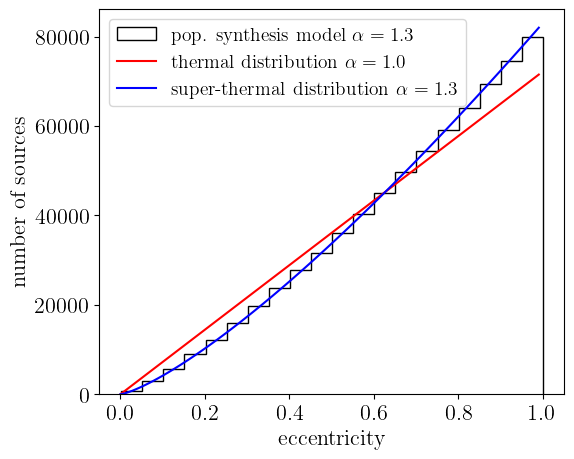

input value in pop synthesis model was 1.3, the actual generated distribution has best-fit alpha of:  1.2820429934391564


In [16]:
# Now for the generated binaries between 1e3 and 1e4 AU: 
plt.figure()
plt.hist(subtable['ecc'], 20, histtype='step', stacked=True, fill=False, color='black', label=r'pop. synthesis model $\alpha=1.3$')
ee=np.arange(0,1,0.01)
mylabel=[r'thermal distribution $\alpha=1.0$', r'super-thermal distribution $\alpha=1.3$']
mycolor=['red', 'blue']
for i,ecc_alpha in enumerate([1.,1.3]):
    plt.plot(ee,(ecc_alpha+1)*ee**ecc_alpha*len(subtable)/20.,color=mycolor[i], label=mylabel[i])
plt.xlabel('eccentricity')
plt.ylabel('number of sources')
plt.legend(loc='upper left')
plt.show()
# OK, this looks reasonable...
print('input value in pop synthesis model was 1.3, the actual generated distribution has best-fit alpha of: ', orbital.max_likelihood_ecc(subtable['ecc']))

<h1>OK, now the initial table is generated, let's evolve it</h1>

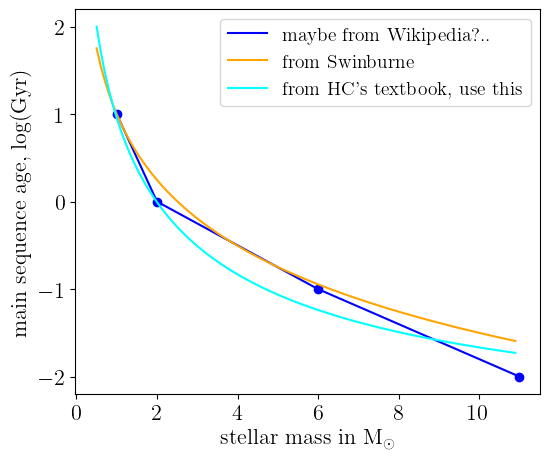

In [17]:
# time on MS
fig=plt.figure()

# this was read off some graph
xx=[11,6,2,1]
yy=np.array([7,8,9,10])-9.
plt.scatter(xx,yy,c='blue')
mass_age = interpolate.interp1d(xx,yy,kind='linear')
xnew=np.arange(1,11,0.1)
plt.plot(xnew,mass_age(xnew),c='blue',label='maybe from Wikipedia?..')

#https://astronomy.swin.edu.au/cosmos/m/main+sequence+lifetime
# this part could really stand to be updated with a better function
def old_t_ms(mass):
    # mass is in solar units, MS lifetime is in Gyears
    return (10.*mass**(-2.5))
mass=np.arange(0.5,11,0.1)
lgt=np.log10(old_t_ms(mass))
plt.plot(mass,lgt,c='orange',label='from Swinburne')

# HCH's formula
def t_ms(mass):
    # input: mass in solar units, 
    # output: log MS lifetime in Gyears
    lgm=np.log10(mass)
    return (10**(9.9551-3.3674*lgm+0.4794*lgm**2+0.3676*lgm**3-0.1013*lgm**4-9.))
plt.plot(mass,np.log10(t_ms(mass)),c='cyan', label='from HC\'s textbook, use this')

plt.xlabel(r'stellar mass in M$_{\odot}$')
plt.ylabel('main sequence age, log(Gyr)')
plt.legend(loc='upper right')
plt.show()

In [18]:
# this is roughly the minimal mass of the star that evolves off the MS during Hubble time
print(t_ms(0.89))
# however, following El-Badry we are assuming that the age of the Galaxy is 12 Gyr, so the more relevant
# value is this one:
print(t_ms(0.92))

13.387629848479648
11.957816585530955


In [19]:
# for each binary, compute the time when primary and secondary evolve to white dwarfs
mybinaries['death1']=mybinaries['bday']+t_ms(mybinaries['m1'])
mybinaries['death2']=mybinaries['bday']+t_ms(mybinaries['m2'])
# and classify the object at present time: 0 is MS-WD, 1 is MS-MS, 2 is WD-WD
# this particular number assignment is definitely a questionnable life choice, but at this point
# we just need to roll with it... 
# sanity check that the more massive star is always m1:
print('sanity check, this should be 0: ', len(mybinaries[(mybinaries['m1']<=mybinaries['m2'])]))
# now assign class 1 to everything: 
mybinaries['class']=np.ones(nbinaries)
ind1=((mybinaries['death1']>present_day) & (mybinaries['death2']>present_day))
# if both evolved off the MS, they are WDs: 
ind2=((mybinaries['death1']<=present_day) & (mybinaries['death2']<=present_day))
mybinaries['class'][ind2]=2
# if only the more massive one evolved off the MS, it's a MS-WD binary: 
ind0=((mybinaries['death1']<=present_day) & (mybinaries['death2']>present_day))
mybinaries['class'][ind0]=0
# one more sanity check: 
ind=((mybinaries['death1']>present_day) & (mybinaries['death2']<=present_day))
print('sanity check, this should be 0: ', len(mybinaries[ind]))
# OK, how many of each? 
print('class 0, an MS-WD binary (in the MS sample appears as single)', len(mybinaries[(mybinaries['class']==0)]), len(mybinaries[ind0]))
print('class 1, an MS-MS binary', len(mybinaries[(mybinaries['class']==1)]), len(mybinaries[ind1]))
print('class 2, a WD-WD binary (does not appear in the MS sample at all)', len(mybinaries[(mybinaries['class']==2)]), len(mybinaries[ind2]))
print('total should be the total number of objects in the simulation: ', len(mybinaries[(mybinaries['class']==0)])+len(mybinaries[(mybinaries['class']==1)])+len(mybinaries[(mybinaries['class']==2)]))#mybinaries[0:10]

sanity check, this should be 0:  0
sanity check, this should be 0:  0
class 0, an MS-WD binary (in the MS sample appears as single) 2808946 2808946
class 1, an MS-MS binary 6853006 6853006
class 2, a WD-WD binary (does not appear in the MS sample at all) 338048 338048
total should be the total number of objects in the simulation:  10000000


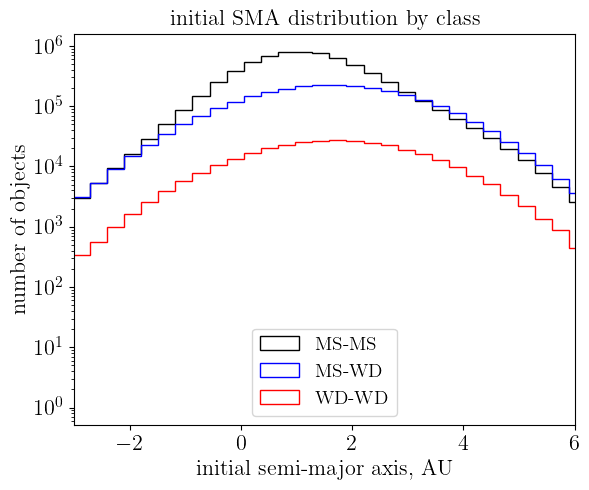

In [20]:
fig=plt.figure()
(n, bins, patches)=plt.hist(np.log10(mybinaries['sma'][ind1]), n_bins, histtype='step', stacked=True, fill=False, color='black', label='MS-MS')
plt.hist(np.log10(mybinaries['sma'][ind0]), bins, histtype='step', stacked=True, fill=False, color='blue', label='MS-WD')
plt.hist(np.log10(mybinaries['sma'][ind2]), bins, histtype='step', stacked=True, fill=False, color='red', label='WD-WD')
plt.legend(loc='lower center')
plt.yscale('log')
plt.xlim((-3.,6.))
plt.xlabel('initial semi-major axis, AU')
plt.ylabel('number of objects')
plt.title('initial SMA distribution by class')
fig.tight_layout() 
plt.show()
# These are slightly different because the period distribution for the massive stars was slightly different, and
# these are more likely to evolve to WDs by present time. 

In [21]:
# let's create properly drawn initial orientations which will apply to the initial conditions and used as needed:
# we are going to have to deal with special cases later: inclinations near 0, pi and pi/2, omega near 0 and pi for
# the Hamiltonian case, they should be excluded. 
mybinaries['omega']=np.random.uniform(low=0., high=2*np.pi, size=len(mybinaries))
mybinaries['asclong']=np.random.uniform(low=0., high=2*np.pi, size=len(mybinaries))
mybinaries['mean_anomaly']=np.random.uniform(low=0., high=2*np.pi, size=len(mybinaries))
# this is selected on a sphere
mybinaries['inc']=np.arccos(1.-np.random.uniform(low=0., high=2., size=len(mybinaries)))

# For objects that would later become WD-WD binaries, there are two steps of the evolution. Before the second step
# all these parameters are randomized again because the axis of the second evolution is randomly oriented relative
# to the binary orbit
mybinaries['omega_step2']=np.random.uniform(low=0., high=2*np.pi, size=len(mybinaries))
mybinaries['asclong_step2']=np.random.uniform(low=0., high=2*np.pi, size=len(mybinaries))
mybinaries['mean_step2']=np.random.uniform(low=0., high=2*np.pi, size=len(mybinaries))
# this is selected on a sphere
mybinaries['inc_step2']=np.arccos(1.-np.random.uniform(low=0., high=2., size=len(mybinaries)))


<h2>This is the total mass loss per Cummings</h2>

In [22]:
def mfinal(minitial):
    # this is the initial-to-final relationship from Cummings et al. 2018
    # supplemented by constant fractional mass loss at M<0.83
    minitial=np.array([minitial])
    ind0=(minitial<=0.83)
    ind1=((minitial>0.83) & (minitial<=2.85))
    ind2=((minitial>2.85) & (minitial<=3.60))
    ind3=((minitial>3.60) & (minitial<=7.20))
    ind4=(minitial>7.20)
    mf=0.*minitial
    mf[ind0]=minitial[ind0]*(0.08*0.83+0.489)/0.83
    mf[ind1]=0.08*minitial[ind1]+0.489
    mf[ind2]=0.187*minitial[ind2]+0.184
    mf[ind3]=0.107*minitial[ind3]+0.471
    mf[ind4]=minitial[ind4]*(0.107*7.2+0.471)/7.2
    if (len(minitial)==1): 
        return(mf[0])
    else:
        return(mf)

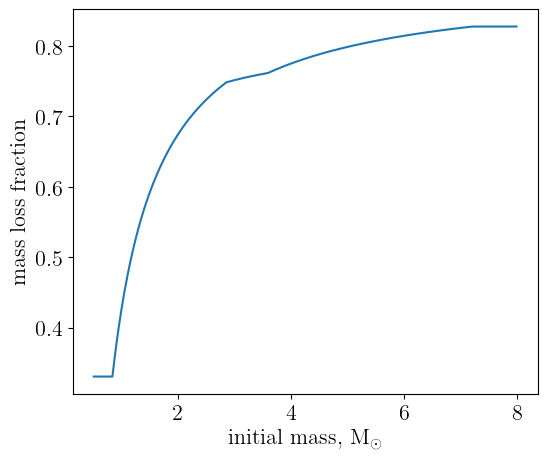

In [23]:
fig=plt.figure()
minitial=np.arange(0.5,8.0,0.01)
plt.plot(minitial,(minitial-mfinal(minitial))/minitial)
plt.xlabel(r'initial mass, M$_{\odot}$')
plt.ylabel('mass loss fraction')
plt.show()

In [24]:
# assign final masses for both components
mybinaries['fm1']=mfinal(mybinaries['m1'])
mybinaries['fm2']=mfinal(mybinaries['m2'])

In [25]:
# let's write this out as the data table
# https://docs.astropy.org/en/stable/io/fits/index.html
mybinaries.write('public_mybinaries_setup.fits', format='fits', overwrite=True)


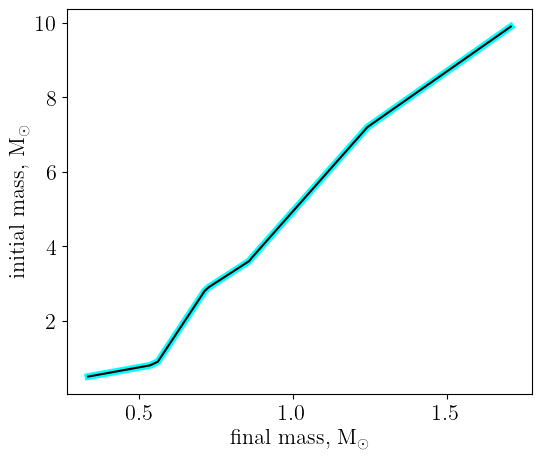

In [26]:
# how do we get initial mass given final mass for Cummings?
from scipy.interpolate import interp1d
minitial=np.arange(0.5,10,0.1)
mf=mfinal(minitial)
plt.figure()
plt.plot(mf,minitial,linewidth=5,color='cyan')
f = interp1d(mf, minitial, kind='cubic')
plt.plot(mf, f(mf), color='black')
plt.xlabel(r'final mass, M$_{\odot}$')
plt.ylabel(r'initial mass, M$_{\odot}$')
plt.show()

<h1>This is the sample of singles</h1>

In [27]:
# generate a population of singles
nsingles=10000000
mysingles=Table()
xm=np.random.uniform(size=nsingles)
mysingles['m']=gen_broken_PL(alpha1,alpha2,mmin,mbreak,mmax,xm)
# uniform birthday distribution from 0 to 12 Gyr, with 12 Gyr being present day: 
mysingles['bday']=np.random.uniform(size=nsingles)*present_day
mysingles['death']=mysingles['bday']+t_ms(mysingles['m'])

In [28]:
# Let's classify these singles at the present day: 
# class 0 if still an MS star
# class 2 if a WD
mysingles['class']=np.zeros(nsingles)
ind=(mysingles['death']<present_day)
mysingles['class'][ind]=2
print('class 0, an MS single', len(mysingles[(mysingles['class']==0)]))
print('class 2, a WD single', len(mysingles[(mysingles['class']==2)]))

class 0, an MS single 8258992
class 2, a WD single 1741008


In [29]:
# The definitive guide to the classes, questionnable though these value choices may be: 
def report_classes():
    print('Binaries: 1 if an MS-MS binary, 0 if an MS-WD binary, 2 if WD-WD binary')
    print('Singles: 0 if an MS single, 2 if a WD single')
    return()

In [30]:
mysingles['fm']=mfinal(mysingles['m'])
mysingles.write('public_mysingles_setup.fits', format='fits', overwrite=True)
mysingles[0:10]

m,bday,death,class,fm
float64,float64,float64,float64,float64
0.5928911088877724,7.8510379222504305,62.7699956233224,0.0,0.39673701430875763
0.39573030510042073,3.9452779887960796,234.02193719423843,0.0,0.26480555596719724
0.40437008296347554,4.7935173824967094,217.8948506462203,0.0,0.2705869205758004
0.34581442464725104,2.195398905373514,373.1483547056577,0.0,0.23140401379407619
0.322593324704815,6.933994859595209,481.04662159392024,0.0,0.21586546089283645
0.6926915620123696,7.012846229807803,38.83282676899689,0.0,0.46351914884538564
0.9345023459905548,8.53333742503179,19.872293305359285,0.0,0.5637601876792444
0.5079218375845778,11.504110702489806,106.38406007652951,0.0,0.33987926336683677
0.6314822114741608,0.09862232694144746,44.091762536285856,0.0,0.4225605063286132


<h1>Let's generate some foundational statistical plots for the MS stars.</h1>


In [31]:
report_classes()

Binaries: 1 if an MS-MS binary, 0 if an MS-WD binary, 2 if WD-WD binary
Singles: 0 if an MS single, 2 if a WD single


()

<h3>Method 2: mock up a more realistic wide binary survey</h3>

In [32]:
# But this is not what we'd be actually observing... Our "binaries" are only those with separations above 1000AU
# and short-period binaries appear as singles
# Let's define what's a wide binary and what's a close binary that's definitely considered a single... 
awide=1000
aclose=10

In [33]:
# and this is the overall observed wide binary fraction of MS stars (kind of reading this off 
# Hsiang-Chih's plot but can be modified for a better observational value):
fbinaries=0.05

If we have $K_b$ number of MS-MS binaries and $K_s$ number of MS singles, and $K_{bs}$ is the number of objects that were born as binaries but are now singles, then our definition of the observed MS binary fraction is $$f_{b}=\frac{2K_b}{2K_b+K_{bs}+K_s}.$$ I.e., we count each star, not the binary category (this is different from some literature definitions which count classes, not individual stars).
We have used $nbinaries$ and $nsingles$, the two (large) values that define our simulated sample sizes. These were kind of randomly selected, so our task now is to use the observed binary fraction $fbinaries$ to calculate the actual ratio of these two for the population statistics plots. Let's say $n$ is the normalization by which the singles need to be enhanced to match the overall observed binary fraction and $N_b$ and $N_{bs}$ are the numbers of MS binaries and MS singles born in binaries in the binaries simulated dataset, and $N_s$ is the number of MS singles in the singles simulated dataset, then $$f_{b}=\frac{2N_b}{2N_b+N_{bs}+nN_s}$$ is the equation connecting the observed binary fraction $f_b$ with the normalization $n$ and it can be inverted to find $n$: $$n=\frac{2N_b/f_b-2N_b-N_{bs}}{N_s}.$$

In [34]:
nbb=len(mybinaries[(mybinaries['class']==1) & (mybinaries['sma']>awide)])
nbc=len(mybinaries[(mybinaries['class']==1) & (mybinaries['sma']<aclose)])
nbs=len(mybinaries[(mybinaries['class']==0)])
ns=len(mysingles[(mysingles['class']==0)])
# this is the one where we ignore the contribution to singles from the binary population
norm_temp=nbb*2*(1./fbinaries-1.)/ns
# and this is the one where we are adding to singles, both from the close binaries and from the 
norm=(nbb*2./fbinaries-nbb*2-nbs-nbc)/ns
print('comparison of the normalizations for the two ways of calculating binary fraction: ', norm, norm_temp)
# OK, the return of the surviving component of the binary to the singles is not a big effect, but the 
# presence of the compact binaries is a big effect

comparison of the normalizations for the two ways of calculating binary fraction:  1.4028039983571845 2.1144565825950674


The binary fraction in some mass bin is equal to $$f_b=\frac{N_b}{nN_s+N_{bb}+N_{bs}+N_{bc}},$$ where $N_{bc}$ is the number of binaries that are so close that they are identified as singles in our survey. Poisson error on each value is $\sqrt{N_i}$, and we consider the overall normalization $n$ to be well-determined (no error), since it's based on a much larger sample. Propagating the error according to the standard equation $$\sigma_{f_b}=\sqrt{\sum\left(\frac{\partial f_b }{\partial N_i}\right)^2\sigma_{N_i}^2}= \sqrt{\sum\left(\frac{\partial f_b }{\partial N_i}\right)^2N_i}=\frac{\sqrt{N_{bb}(nN_s+N_{bs}+N_{bc})^2+N_{bb}^2(n^2N_s+N_{bb}+N_{bs}+N_{bc})}}{(nN_s+N_{bb}+N_{bs}+N_{bc})^2}.$$


In [35]:
# try a couple of different mbinning methods: start with just linear mbins in log mass
lgmbin=np.linspace(np.log10(mmin),np.log10(mmax),7)
lgcmbin=0.5*(lgmbin[1:len(lgmbin)]+lgmbin[0:len(lgmbin)-1])
mbin=10**lgmbin
cmbin=10**lgcmbin
# this will be the number of stars in binaries, stars in binaries that became singles, and stars in singles 
# in each mass bin
num_bb=np.zeros(len(cmbin))
num_bc=np.zeros(len(cmbin))
num_bs=np.zeros(len(cmbin))
num_s=np.zeros(len(cmbin))
for i,cm in enumerate(cmbin):
    # isolate all objects that are still binaries and where the mass is in the relevant regime and separation is in the relevant regime
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['class']==1) & (mybinaries['sma']>awide))
    ind2=((mybinaries['m2']>=mbin[i]) & (mybinaries['m2']<mbin[i+1]) & (mybinaries['class']==1) & (mybinaries['sma']>awide))
    num_bb[i]=len(mybinaries[ind1])+len(mybinaries[ind2])
    # for the binaries contributing to singles, we are counting the surviving star not the dead star
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['class']==0) & (mybinaries['death1']>present_day))
    print('this really should be 0:', len(mybinaries[ind1]))
    ind2=((mybinaries['m2']>=mbin[i]) & (mybinaries['m2']<mbin[i+1]) & (mybinaries['class']==0) & (mybinaries['death2']>present_day))
    num_bs[i]=len(mybinaries[ind1])+len(mybinaries[ind2])
    # for the close binaries contributing to singles, we are counting the more massive star
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['class']==1) & (mybinaries['sma']<aclose))
    num_bc[i]=len(mybinaries[ind1])
    # and these are the original singles that are still on the MS: 
    ind=((mysingles['m']>=mbin[i]) & (mysingles['m']<mbin[i+1]) & (mysingles['class']==0))
    num_s[i]=len(mysingles[ind])
# observed binary fraction as a function of mass:
obs_fbinaries=num_bb/(norm*num_s+num_bb+num_bs+num_bc)
# shot noise on that statement, let's consider the normalization to be perfectly determined:
obs_error_fbinaries=np.sqrt(num_bb*(norm*num_s+num_bs+num_bc)**2+(norm**2*num_s+num_bs+num_bc)*num_bb**2)/(norm*num_s+num_bb+num_bs+num_bc)**2
obs_error_easy=np.sqrt(num_bb)/(norm*num_s)
print(obs_error_fbinaries, obs_error_easy)
# the "easy" error is no longer so similar to the actual error because singles no longer dominate by such a large factor... 

this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
[5.99849642e-05 8.13350399e-05 2.15510480e-04 7.71783622e-04
 2.48137784e-03 7.28384784e-03] [8.83223570e-05 1.41710101e-04 4.11221118e-04 1.44815346e-03
 4.59379010e-03 1.36179064e-02]


In [36]:
# same but at birth:
birth_bb=np.zeros(len(cmbin))
birth_bc=np.zeros(len(cmbin))
birth_s=np.zeros(len(cmbin))
for i,cm in enumerate(cmbin):
    # isolate all objects where the mass is in the relevant regime
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['sma']>awide))
    ind2=((mybinaries['m2']>=mbin[i]) & (mybinaries['m2']<mbin[i+1]) & (mybinaries['sma']>awide))
    birth_bb[i]=len(mybinaries[ind1])+len(mybinaries[ind2])
    # and these are the singles with the relevant mass
    ind=((mysingles['m']>=mbin[i]) & (mysingles['m']<mbin[i+1]))
    birth_s[i]=len(mysingles[ind])
    # for the close binaries contributing to singles, we are counting the more massive star
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['sma']<aclose))
    birth_bc[i]=len(mybinaries[ind1])
# binary fraction as a function of mass: since each surviving star has already been counted individually
# here we don't need to multiply the number of binaries by 2
birth_fbinaries=birth_bb/(norm*birth_s+birth_bc+birth_bb)
# shot noise on that statement, let's consider the normalization to be perfectly determined:
birth_error_fbinaries=np.sqrt(birth_bb*(norm*birth_s+birth_bc)**2+birth_bb**2*(norm**2*birth_s+birth_bb+birth_bc))/(norm*birth_s+birth_bb+birth_bc)**2

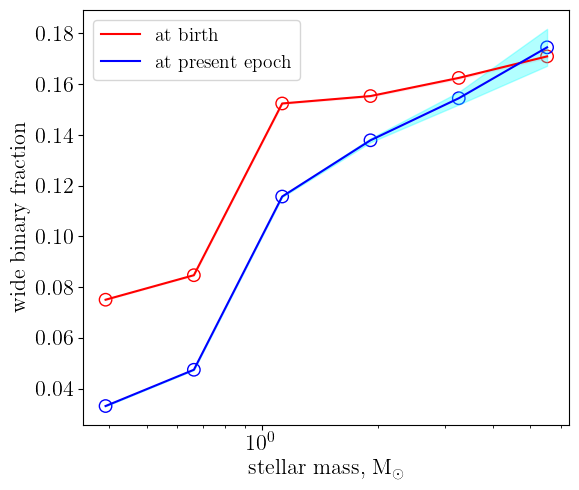

In [37]:
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(cmbin,birth_fbinaries, s=80, facecolors='none', edgecolors='red')
plt.plot(cmbin,birth_fbinaries, color='red', label='at birth')
plt.fill_between(cmbin,birth_fbinaries-birth_error_fbinaries,birth_fbinaries+birth_error_fbinaries, color='pink', alpha=0.3)
plt.scatter(cmbin,obs_fbinaries, s=80, facecolors='none', edgecolors='blue')
plt.plot(cmbin,obs_fbinaries, color='blue', label='at present epoch')
plt.fill_between(cmbin,obs_fbinaries-obs_error_fbinaries,obs_fbinaries+obs_error_fbinaries, color='cyan', alpha=0.3)
#plt.ylim((0.045,0.075))
plt.xlabel(r'stellar mass, M$_{\odot}$')
plt.ylabel('wide binary fraction')
plt.xscale('log')
#plt.tick_params(axis='x', which='minor')
plt.legend(loc='upper left')
fig.tight_layout()
plt.savefig('public_setup_ms_ms_wide.png', dpi=300)
plt.show()


<h3>Unfortunately this figure is very sensitive to the assumed period distribution as a function of mass.</h3> 
<p>This assumption enters in two ways. One is $N_{bb}$, the number of binaries with separations $>$1000AU, so if there is a strong mass dependence at birth there, it will also continue at present day. The other is $N_{bc}$, the number of close binaries as a function of mass, which enters the denominator of our binary fraction calculation. <p>Here is what this exact same figure looks like if we say lgp=lgp1 all the way where we are setting up the period distribution of our binaries (i.e., no dependence of period distribution on mass). There is still a slight variation as a function of mass of the binary fraction at birth because there is a mass-dependent semi-major axis distribution. 

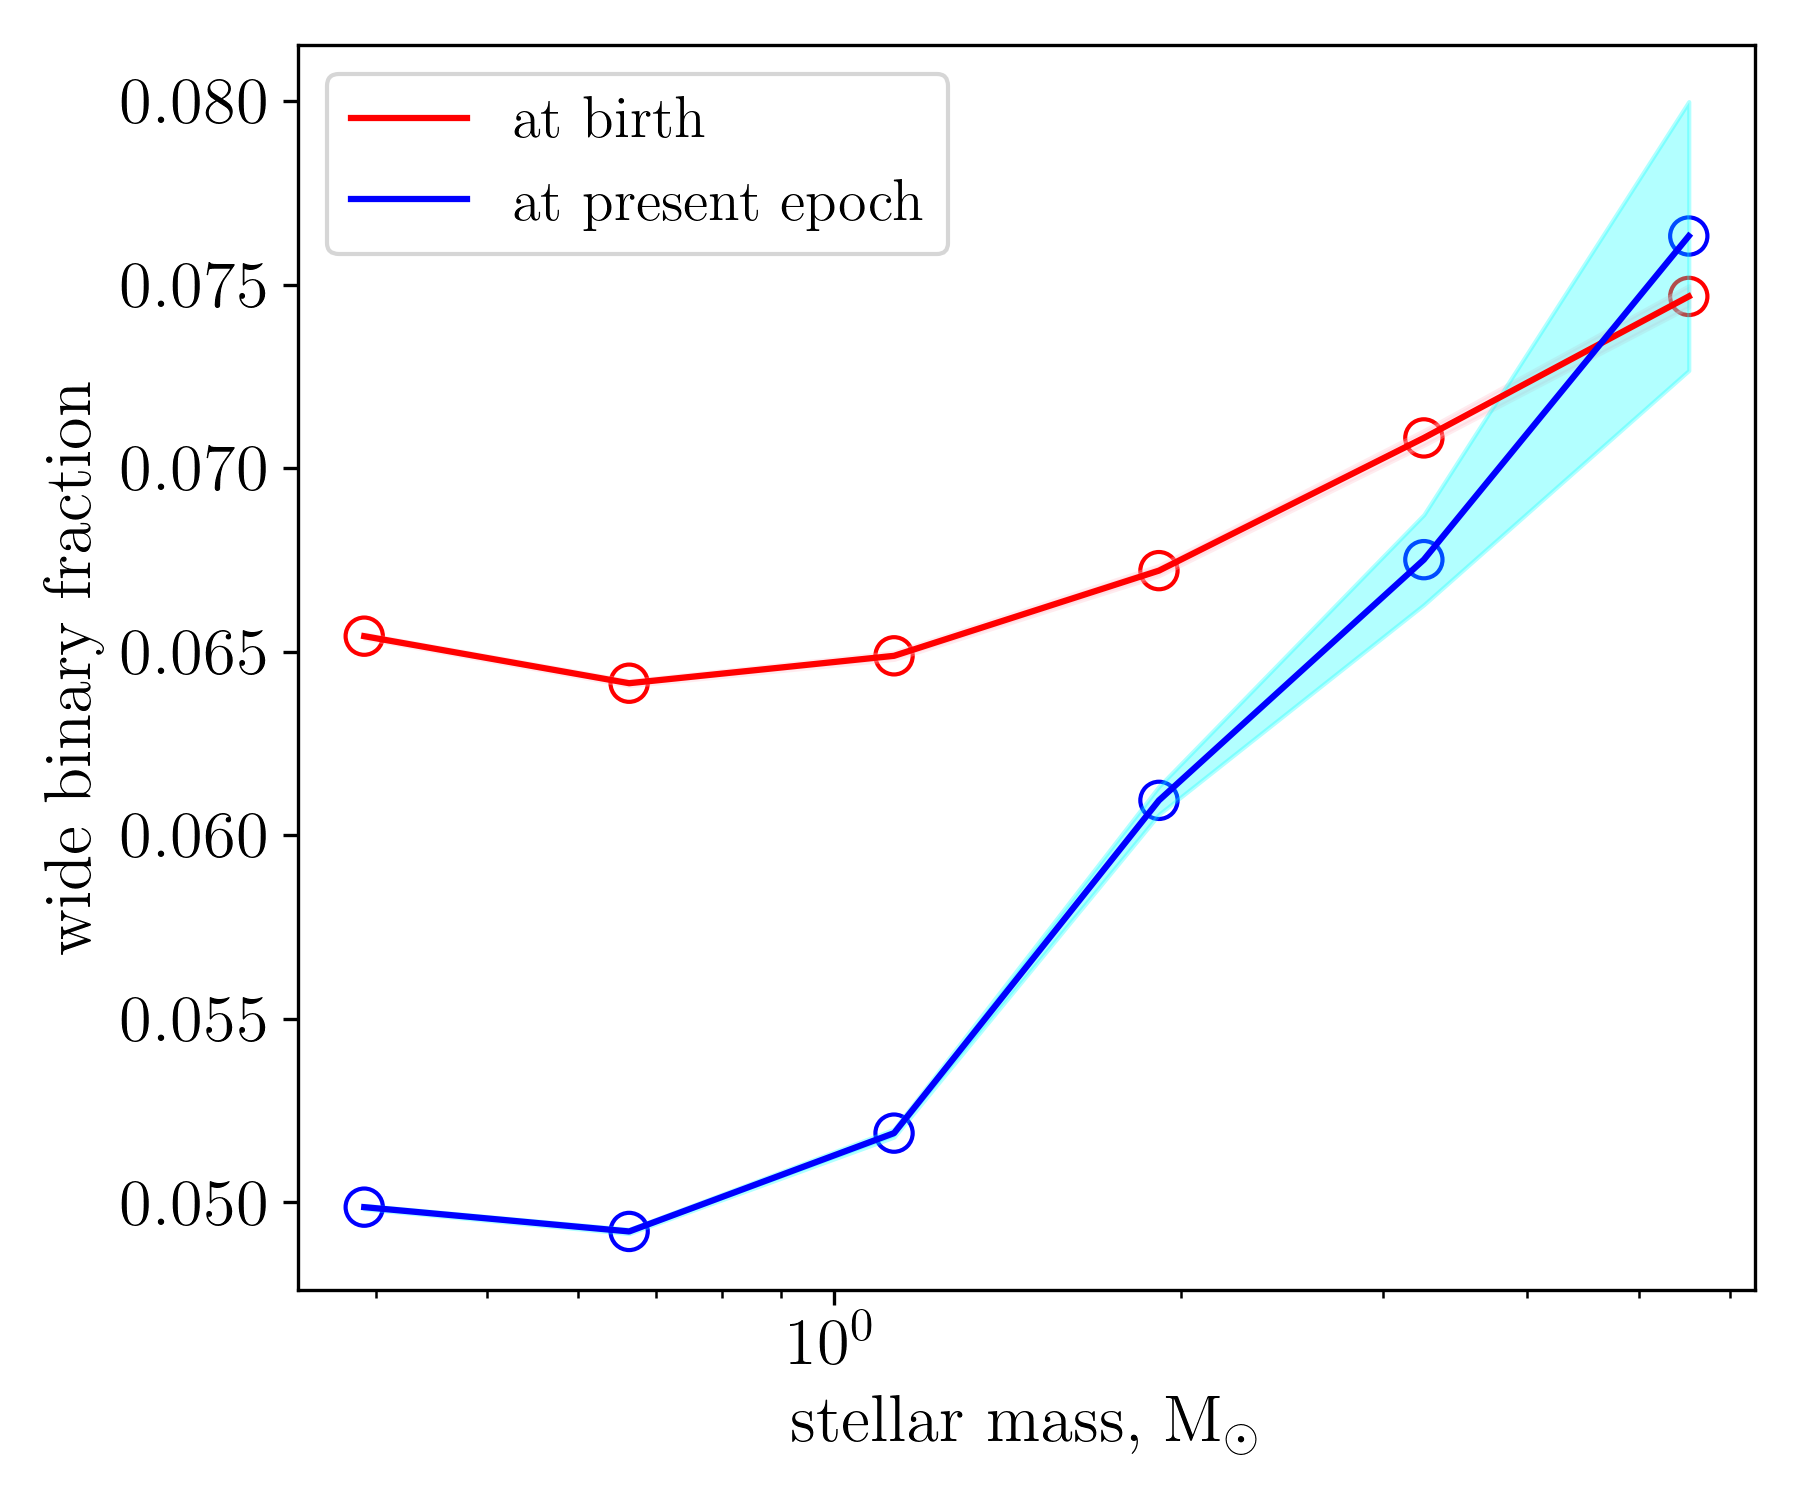

In [38]:
from IPython.display import Image
Image(filename='public_setup_ms_ms_wide_lgp1_1e7.png', width=500)


<h3>Method 1: compute the mass dependence for all binaries (close and wide together)</h3>

In [39]:
# this is the normalization between nsingles and nbinaries if we normalize the populations 
#by the wide-binary fraction:
print(norm, norm_temp)
# compute fbinaries for the overall fraction of binaries
nb=len(mybinaries[(mybinaries['class']==1)])
nbs=len(mybinaries[(mybinaries['class']==0)])
ns=len(mysingles[(mysingles['class']==0)])
all_fbinaries=2*nb/(2*nb+nbs+norm*ns)
print('overall binary fraction in the population with wide binary fraction ', fbinaries, ' :', all_fbinaries)

1.4028039983571845 2.1144565825950674
overall binary fraction in the population with wide binary fraction  0.05  : 0.4877461971149834


In [40]:
# We could define the overall fbinaries and recompute the normalization:
def recompute(fbinaries=all_fbinaries):
    # Let's consider only the MS stars for the moment. 
    # this is the factor by which the number of singles needs to be enhanced to match the overall
    # observed binary fraction if we are not adding from binaries to singles:
    nb=len(mybinaries[(mybinaries['class']==1)])
    nbs=len(mybinaries[(mybinaries['class']==0)])
    ns=len(mysingles[(mysingles['class']==0)])
    # this is if the return from the binary population to the single population is negligible: 
    norm_temp=nb*2*(1./fbinaries-1.)/ns
    # and this is the one where we are adding MS-WD binaries to MS singles:
    norm=(nb*2./fbinaries-nb*2-nbs)/ns
    print('with and without taking into account the return of the surviving MS-WD binaries to the MS singles', norm, norm_temp)
    # OK, the return of the surviving MS-WD binaries to the MS singles population is not a big effect
    return(norm,norm_temp)
recompute()
# indeed, norm is the same

with and without taking into account the return of the surviving MS-WD binaries to the MS singles 1.4028039983571845 1.742911604709146


(1.4028039983571845, 1.742911604709146)

In [41]:
print(norm)

1.4028039983571845


The binary fraction in some mass bin is equal to $$f_b=\frac{N_b}{nN_s+N_{bb}+N_{bs}}.$$ Poisson error on each value is $\sqrt{N_i}$, and we consider the overall normalization $n$ to be well-determined (no error), since it's based on a much larger sample. Propagating the error according to the standard equation $$\sigma_{f_b}=\sqrt{\sum\left(\frac{\partial f_b }{\partial N_i}\right)^2\sigma_{N_i}^2}= \sqrt{\sum\left(\frac{\partial f_b }{\partial N_i}\right)^2N_i}=\frac{\sqrt{N_{bb}(nN_s+N_{bs})^2+N_{bb}^2(n^2N_s+N_{bb}+N_{bs})}}{(nN_s+N_{bb}+N_{bs})^2}.$$ In this expression, it looks like for realistic fractions $nN_s$ is much greater than everything else, so $$\sigma_{f_b}\simeq \frac{\sqrt{N_{bb}}}{nN_s}.$$

In [42]:
# Here we are plotting the binary fraction as a function of mass for MS stars
# try a couple of different mbinning methods: start with just linear mbins in log mass
lgmbin=np.linspace(np.log10(mmin),np.log10(mmax),11)
lgcmbin=0.5*(lgmbin[1:len(lgmbin)]+lgmbin[0:len(lgmbin)-1])
mbin=10**lgmbin
cmbin=10**lgcmbin
# this will be the number of stars in binaries, stars in binaries that became singles, and stars in singles 
# in each mass bin
num_bb=np.zeros(len(cmbin))
num_bs=np.zeros(len(cmbin))
num_s=np.zeros(len(cmbin))
for i,cm in enumerate(cmbin):
    # isolate all objects that are still binaries and where the mass is in the relevant regime
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['class']==1))
    ind2=((mybinaries['m2']>=mbin[i]) & (mybinaries['m2']<mbin[i+1]) & (mybinaries['class']==1))
    num_bb[i]=len(mybinaries[ind1])+len(mybinaries[ind2])
    # for the binaries contributing to singles, we are counting the surviving star not the evolved star
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]) & (mybinaries['class']==0) & (mybinaries['death1']>present_day))
    print('this really should be 0:', len(mybinaries[ind1]))
    ind2=((mybinaries['m2']>=mbin[i]) & (mybinaries['m2']<mbin[i+1]) & (mybinaries['class']==0) & (mybinaries['death2']>present_day))
    num_bs[i]=len(mybinaries[ind1])+len(mybinaries[ind2])
    # and these are the original singles that are still on the MS
    ind=((mysingles['m']>=mbin[i]) & (mysingles['m']<mbin[i+1]) & (mysingles['class']==0))
    num_s[i]=len(mysingles[ind])
# observed binary fraction as a function of mass: since each surviving star has already been counted individually
# here we don't need to multiply the number of binaries by 2
obs_fbinaries=num_bb/(norm*num_s+num_bb+num_bs)
# shot noise on that statement, let's consider the normalization to be perfectly determined:
obs_error_fbinaries=np.sqrt(num_bb*(norm*num_s+num_bs)**2+num_bb**2*(norm**2*num_s+num_bb+num_bs))/(norm*num_s+num_bb+num_bs)**2
obs_error_easy=np.sqrt(num_bb)/(norm*num_s)
print(obs_error_fbinaries, obs_error_easy)
# OK, N_s completely dominates everything for the purposes of error calculation, so the "easy" error should be quite close... 

this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
this really should be 0: 0
[0.0002086  0.00022125 0.00026362 0.00034075 0.00066726 0.00140264
 0.00282534 0.00547651 0.01030069 0.01841859] [0.000555   0.0005887  0.00070239 0.00090536 0.00176898 0.0036891
 0.00743462 0.0143066  0.02763414 0.04825289]


In [43]:
# same but at birth:
birth_bb=np.zeros(len(cmbin))
birth_s=np.zeros(len(cmbin))
for i,cm in enumerate(cmbin):
    # isolate all objects where the mass is in the relevant regime
    ind1=((mybinaries['m1']>=mbin[i]) & (mybinaries['m1']<mbin[i+1]))
    ind2=((mybinaries['m2']>=mbin[i]) & (mybinaries['m2']<mbin[i+1]))
    birth_bb[i]=len(mybinaries[ind1])+len(mybinaries[ind2])
    # and these are the singles with the relevant mass
    ind=((mysingles['m']>=mbin[i]) & (mysingles['m']<mbin[i+1]))
    birth_s[i]=len(mysingles[ind])
# binary fraction as a function of mass: since each surviving star has already been counted individually
# here we don't need to multiply the number of binaries by 2
birth_fbinaries=birth_bb/(norm*birth_s+birth_bb)
# shot noise on that statement, let's consider the normalization to be perfectly determined:
birth_error_fbinaries=np.sqrt(birth_bb*(norm*birth_s)**2+birth_bb**2*(norm**2*birth_s+birth_bb))/(norm*birth_s+birth_bb)**2

In [44]:
# compare to the analytical solution from the Appendix
pintegral=mbreak*(alpha2-alpha1)/((alpha1+1)*(alpha2+1))+mbreak*((mmax/mbreak)**(alpha2+1)/(alpha2+1)-(mmin/mbreak)**(alpha1+1)/(alpha1+1))
def prob(m):
    # is m greater than mbreak? this function is equal to 1 if yes and 0 otherwise
    mgmbreak=0.5*(np.sign(m-mbreak)+1)
    return(mgmbreak*(m/mbreak)**alpha2/pintegral+(1.-mgmbreak)*(m/mbreak)**alpha1/pintegral)
(AS,error_AS,an_birth_fbinaries,error_an_birth_fbinaries)=ancillary.calculate_normalization(prob, t_ms, mmin, mmax, fbinaries=all_fbinaries, ntrials=1000000, tol=0.01)
all_mass1=10**lgcmbin
bf=np.zeros(len(all_mass1))
error_bf=np.zeros(len(all_mass1))
for i, mass1 in enumerate(all_mass1):
    (bin_fraction,error_bin_fraction)=ancillary.calculate_fraction(prob,t_ms,mmin,mmax,mass1,AS,error_AS,tol=0.03)
    bf[i]=bin_fraction
    error_bf[i]=error_bin_fraction

fractional errors: s, bsbb, bb 0.0035505438308357285 0.0033343937475304236 0.003982925361618809
theoretical normalization, error, relative error 1.3900040550371215 0.015819576008278664 0.011380956732429235
fractional errors 0.003162293471517152 0.009355196321520634 0.011214115741935489
bin_fraction, error, rel. error 0.4950979008377886 0.006636574784648648 0.013404570638288815
fractional errors 0.003162293471517152 0.00931442221004389 0.011328913267740857
bin_fraction, error, rel. error 0.4787817394556123 0.006458276965060298 0.01348897928397088
fractional errors 0.003162293471517152 0.009373430869620513 0.011280985157544802
bin_fraction, error, rel. error 0.4813221194483116 0.0064809053030771 0.013464798398431123
fractional errors 0.003162293471517152 0.009335896022653228 0.011264312875720833
bin_fraction, error, rel. error 0.48315890381490784 0.006493942524787016 0.013440593712570314
fractional errors 0.005320530525031115 0.015698098686616344 0.017506339705059878
bin_fraction, error,

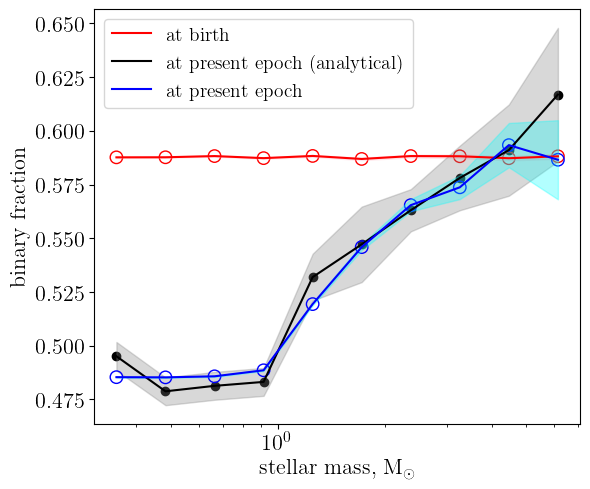

In [45]:
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(all_mass1, bf,color='black')
plt.scatter(cmbin,birth_fbinaries, s=80, facecolors='none', edgecolors='red')
plt.plot(cmbin,birth_fbinaries, color='red', label='at birth')
plt.fill_between(cmbin,birth_fbinaries-birth_error_fbinaries,birth_fbinaries+birth_error_fbinaries, color='pink', alpha=0.3)
plt.plot(all_mass1, bf,color='black', label='at present epoch (analytical)')
# This agrees with the other "at birth" line, so  I am removing the analytical calculation 
#plt.plot(all_mass1, np.ones(len(all_mass1))*an_birth_fbinaries, color='magenta', label='at birth (analytical)')
plt.fill_between(all_mass1, bf-error_bf, bf+error_bf, color='grey', alpha=0.3)
plt.scatter(cmbin,obs_fbinaries, s=80, facecolors='none', edgecolors='blue')
plt.plot(cmbin,obs_fbinaries, color='blue', label='at present epoch')
plt.fill_between(cmbin,obs_fbinaries-obs_error_fbinaries,obs_fbinaries+obs_error_fbinaries, color='cyan', alpha=0.3)
# check that the approximate error works well too: 
#plt.fill_between(cmbin,obs_fbinaries-obs_error_easy,obs_fbinaries+obs_error_easy, color='grey', alpha=0.3)
#plt.ylim((0.045,0.07))
plt.xlabel(r'stellar mass, M$_{\odot}$')
plt.ylabel('binary fraction')
plt.xscale('log')
#plt.tick_params(axis='x', which='minor')
plt.legend(loc='upper left')
fig.tight_layout()
plt.savefig('public_setup_ms_ms.png', dpi=300)
plt.show()
# At birth, there was no mass dependence for the binary fraction by design, since we 
# generated binary component masses independently from the same underlying distribution. 
# At present epoch, low mass stars are more likely to be singles than at birth because many of their
# companions have evolved off the MS. High mass stars have the same binary fraction as they did at birth
# because they are all very young so their companions haven't had a chance to evolve. 